In [8]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import sklearn.datasets
#import sklearn.feature_extraction.text
#import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import igraph as ig
from scipy.sparse import vstack
sns.set()
import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show
from collections import Counter

import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors


Loading BokehJS ...

# NCI Datasets

We build one large graph from 4000+ smaller ones (there are 2 datasets, NCI1 and NCI109)
For each vertex, we have the following attributes:
* name:  unique for each vertex (1-based str)
* graph: the small graph this node belongs to (1-based int)
* label: the vertex label (1-based int)

Note that some vertices have label and are assigned to a small graph, but are not part of any edge.
We add those as isolated vertices nevertheless.

Each small graph belongs to one of two classes; the classes are roughly balanced.


In [9]:
datadir = '../Data/NCI1/'
fn_graph_label = datadir+'DS_graph_labels.txt'
## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]


In [10]:
import pickle
#with open('features_NCI1.pkl','rb') as fp:
#    graph_awe_matrix_0, graph_awe_matrix_norm_0, graph_awe_matrix_1, graph_awe_matrix_2, graph_awe_matrix_svd_1, graph_awe_matrix_svd_2 = pickle.load(fp)
with open('features_NCI1.pkl','rb') as fp:
    graph_awe_matrix_0, graph_awe_matrix_norm_0 = pickle.load(fp)
with open('walks_NCI1.pkl','rb') as fp:
    walks_awe_matrix, walks_awe_matrix_norm = pickle.load(fp)
with open('probes_4_NCI1.pkl','rb') as fp:
    probes_4 = pickle.load(fp)
with open('probes_8_NCI1.pkl','rb') as fp:
    probes_8 = pickle.load(fp)
with open('probes_12_NCI1.pkl','rb') as fp:
    probes_12 = pickle.load(fp)
with open('probes_16_NCI1.pkl','rb') as fp:
    probes_16 = pickle.load(fp)

In [11]:
def cross_validate(model, data, labels, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, labels, cv=splitter)
    return result

def cross_validation_dataframe(model, data, labels, feature_sets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, labels, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores,
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

In [12]:
models_norm = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=9, weights="distance"),
    sklearn.ensemble.RandomForestClassifier(),
]
feature_sets_norm = {
    "Expander": graph_awe_matrix_0,
    "Expander normalized":  graph_awe_matrix_norm_0,
#    "W1": graph_awe_matrix_1,
#    "W1s": graph_awe_matrix_svd_1,
#    "Expander+2": graph_awe_matrix_2,
#    "W2s": graph_awe_matrix_svd_2,
    "Walks": walks_awe_matrix,
#    "Walks normalized": walks_awe_matrix_norm,
    "Probes_4": probes_4,
    "Probes_8": probes_8,
    "Probes_12": probes_12,
    "Probes_16": probes_16    
}

In [13]:
%%time
results_norm = []
for model in models_norm:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets_norm,
        graph_labels,
        feature_sets = feature_sets_norm
    )
    results_norm.append(res)

df_norm = pd.concat( results_norm )

KNeighborsClassifier(metric='cosine', n_neighbors=9, weights='distance')
RandomForestClassifier()
CPU times: user 12min 22s, sys: 4min 2s, total: 16min 24s
Wall time: 5min 55s


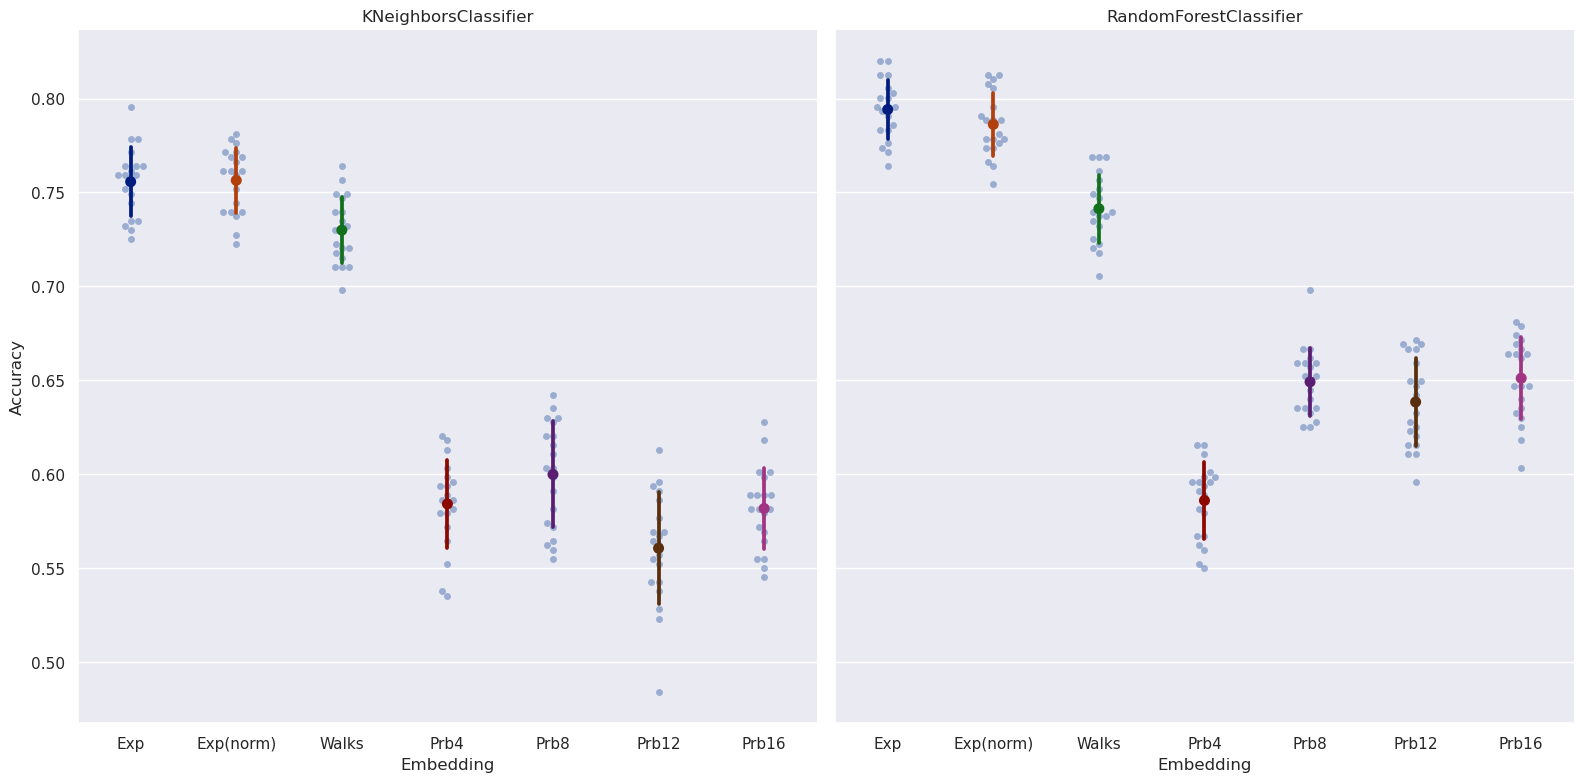

In [14]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df_norm, 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df_norm, 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Expander",
        "Expander normalized",
#        "W1",
#        "W1s",
#        "Expander+2",
#        "W2s",
        "Walks",
#        "Walks normalized",
        "Probes_4",
        "Probes_8",
        "Probes_12",
        "Probes_16"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
        "Exp",
        "Exp(norm)",
#        "W1",
#        "W1s",
#        "Exp+2",
#        "W2s",
        "Walks",
#        "Wkn",
        "Prb4",
        "Prb8",
        "Prb12",
        "Prb16"
    ]);
